Created on Wed Jun 03 15:23 2020

Plot Figure B1, Figure 5 and compute results for Table 1, based on results from prepare_sens_ranges.sh, prepare_sensexp_data.py, and prepare_sensexp_output_for_figure5.sh

@author: Clara Burgard

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import matplotlib as mpl
import cmocean

READ IN THE DATA

In [2]:
assim='SICCI2' # can also be used with 'Bootstrap' and 'NASATeam' but not shown in paper

In [3]:
mod_inputpath0 = '/work/mh0033/m300411/SatSim/WORK_DATA/simulated_TBs/'
if assim=='SICCI2':
    mod_inputpath = mod_inputpath0+'20200603-2009/'#SICCI
elif assim=='Bootstrap':
    mod_inputpath = mod_inputpath0+'20200604-0904/'#Bootstrap
elif assim=='NASATeam':
    mod_inputpath = mod_inputpath0+'20200604-0918/'#NASATeam
plot_path = '/work/mh0033/m300411/SatSim/PLOTS/'

Read in some of the data to fix boundaries (lat,lon,time)

In [4]:
test = xr.open_dataset(mod_inputpath+'sicplus/March/mergetime/TBtotdiff_assim_2004-2008_03_7_hole.nc')
test1 = xr.open_dataset(mod_inputpath+'sicplus/October/mergetime/TBtotdiff_assim_2004-2008_10_7_hole.nc')
test3 = xr.open_dataset(mod_inputpath0+'var_sens/SICCI2/seaice_SICCI2_50km_echam6_03_ensstd_siconly_hole.nc')
test4 = xr.open_dataset(mod_inputpath0+'var_sens/SICCI2/seaice_SICCI2_50km_echam6_10_ensstd_siconly_hole.nc')

In [5]:
timelength_March = test.time
timelength_Oct = test1.time
timelength_March_input = test3.time
timelength_Oct_input = test4.time
lat = test.lat
lon = test.lon

# most southerly latitude plotted
lat_lim = 45

# needed to plot a circle later
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpl.path.Path(verts * radius + center) 

Prepare the datasets

In [6]:
# Modulated variables
ds_input_March = xr.Dataset({'sic': (['time','lat','lon','plus_minus'], np.zeros((len(timelength_March_input),len(lat),len(lon),2))),
                'sit': (['time','lat','lon','plus_minus'], np.zeros((len(timelength_March_input),len(lat),len(lon),2))),
                'snow': (['time','lat','lon','plus_minus'], np.zeros((len(timelength_March_input),len(lat),len(lon),2))),
                'temp': (['time','lat','lon','plus_minus'], np.zeros((len(timelength_March_input),len(lat),len(lon),2)))
                                       },
                coords={'time': timelength_March_input,'lat': lat,'lon': lon,'plus_minus': ['plus','minus']})

ds_input_October = xr.Dataset({'sic': (['time','lat','lon','plus_minus'], np.zeros((len(timelength_Oct_input),len(lat),len(lon),2))),
                'sit': (['time','lat','lon','plus_minus'], np.zeros((len(timelength_Oct_input),len(lat),len(lon),2))),
                'snow': (['time','lat','lon','plus_minus'], np.zeros((len(timelength_Oct_input),len(lat),len(lon),2))),
                'temp': (['time','lat','lon','plus_minus'], np.zeros((len(timelength_Oct_input),len(lat),len(lon),2)))
                                       },
                coords={'time': timelength_Oct_input,'lat': lat,'lon': lon,'plus_minus': ['plus','minus']})

In [7]:
# Resulting brightness temperature differences
ds_March = xr.Dataset({'sic': (['time','lat','lon','plus_minus'], np.zeros((len(timelength_March),len(lat),len(lon),2))),
                'sit': (['time','lat','lon','plus_minus'], np.zeros((len(timelength_March),len(lat),len(lon),2))),
                'snow': (['time','lat','lon','plus_minus'], np.zeros((len(timelength_March),len(lat),len(lon),2))),
                'temp': (['time','lat','lon','plus_minus'], np.zeros((len(timelength_March),len(lat),len(lon),2))),
                                       },

                coords={'time': timelength_March,'lat': lat,'lon': lon,'plus_minus': ['plus','minus']})

ds_October = xr.Dataset({'sic': (['time','lat','lon','plus_minus'], np.zeros((len(timelength_Oct),len(lat),len(lon),2))),
                'sit': (['time','lat','lon','plus_minus'], np.zeros((len(timelength_Oct),len(lat),len(lon),2))),
                'snow': (['time','lat','lon','plus_minus'], np.zeros((len(timelength_Oct),len(lat),len(lon),2))),
                'temp': (['time','lat','lon','plus_minus'], np.zeros((len(timelength_Oct),len(lat),len(lon),2))),
                                       },

                coords={'time': timelength_Oct,'lat': lat,'lon': lon,'plus_minus': ['plus','minus']})


In [8]:
# limits for the colorbar
v_limits = xr.Dataset({'sic': (['direction'], np.zeros(2)),
                'sit': (['direction'], np.zeros(2)),
                'snow': (['direction'], np.zeros(2)),
                'temp': (['direction'], np.zeros(2))
                                       },
                coords={'direction': ['vmax','vmin']})
v_limits['sic'].loc[dict(direction='vmin')] = 0
v_limits['sic'].loc[dict(direction='vmax')] = 45
v_limits['sit'].loc[dict(direction='vmin')] = 0
v_limits['sit'].loc[dict(direction='vmax')] = 60
v_limits['snow'].loc[dict(direction='vmin')] = 0
v_limits['snow'].loc[dict(direction='vmax')] = 15
v_limits['temp'].loc[dict(direction='vmin')] = 0
v_limits['temp'].loc[dict(direction='vmax')] = 9

Filling up the datasets with data from netcdf files

In [9]:
for var in ['sic','sit','temp','snow']:
    print(var)
    
    if var=='sic':
        var1 = 'seaice'
    elif var=='sit':
        var1 = 'siced'
    elif var=='temp':
        var1 = 'tsi'
    elif var=='snow':
        var1 = 'sni'
    
    for plus_minus in ['plus','minus']:
        for mon in ['March','October']:
            if mon == 'March':
                mm = 3
                ds_March[var].loc[dict(plus_minus=plus_minus)] = xr.open_dataset(mod_inputpath+var+plus_minus+'/'+mon+'/mergetime/TBtotdiff_assim_2004-2008_'+str(mm).zfill(2)+'_7_hole.nc')['TBV']
                if assim == 'SICCI2':
                    ds_input_March[var].loc[dict(plus_minus=plus_minus)] = xr.open_dataset(mod_inputpath0+'var_sens/SICCI2/'+var1+'_SICCI2_50km_echam6_'+str(mm).zfill(2)+'_ensstd_siconly_hole.nc')[var1]
                else:
                    ds_input_March[var].loc[dict(plus_minus=plus_minus)] = xr.open_dataset(mod_inputpath0+'var_sens/'+assim+'/'+var1+'_'+assim+'_echam6_'+str(mm).zfill(2)+'_ensstd_siconly_hole.nc')[var1]
              
            elif mon == 'October':
                mm = 10
                ds_October[var].loc[dict(plus_minus=plus_minus)] = xr.open_dataset(mod_inputpath+var+plus_minus+'/'+mon+'/mergetime/TBtotdiff_assim_2004-2008_'+str(mm).zfill(2)+'_7_hole.nc')['TBV']
                if assim == 'SICCI2':
                    ds_input_October[var].loc[dict(plus_minus=plus_minus)] = xr.open_dataset(mod_inputpath0+'var_sens/SICCI2/'+var1+'_SICCI2_50km_echam6_'+str(mm).zfill(2)+'_ensstd_siconly_hole.nc')[var1]
                else:
                    ds_input_October[var].loc[dict(plus_minus=plus_minus)] = xr.open_dataset(mod_inputpath0+'var_sens/'+assim+'/'+var1+'_'+assim+'_echam6_'+str(mm).zfill(2)+'_ensstd_siconly_hole.nc')[var1]


sic
sit
temp
snow


Read in the masks (where sea ice is present)

In [10]:
test_mask_03 = xr.open_dataset(mod_inputpath0+'var_sens/SICCI2/seaice_SICCI2_50km_echam6_03_siconly_testmask_hole.nc')
test_mask_10 = xr.open_dataset(mod_inputpath0+'var_sens/SICCI2/seaice_SICCI2_50km_echam6_10_siconly_testmask_hole.nc')

In [11]:
# sea-ice concentration above 10% to avoid spurious results in very marginal regions
mask03 = test_mask_03['seaice'].mean('time').where(test_mask_03['seaice'].mean('time')>0.1)
mask10 = test_mask_10['seaice'].mean('time').where(test_mask_10['seaice'].mean('time')>0.1)


/home/mpim/m300411/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


PLOT FIGURE B1 lower row

/home/mpim/m300411/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/mpim/m300411/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/mpim/m300411/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/mpim/m300411/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


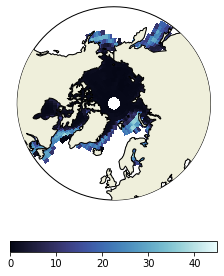

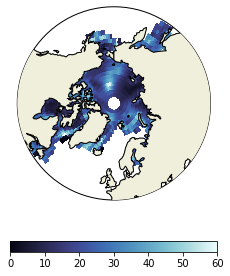

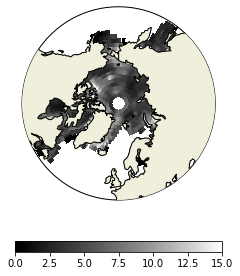

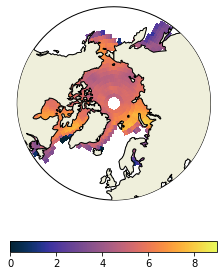

In [14]:
for var in ['sic','sit','snow','temp']:
    values_plot = ds_input_March[var].sel(plus_minus='plus').mean('time').where(np.isnan(mask03)==False).values
    wrap_param, wrap_lon = add_cyclic_point(values_plot,coord=lon,axis=1)
    
    f = plt.figure()
    f.set_size_inches(8.27/2,8.27/2)

    ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
    cs = ax.coastlines(resolution='110m', linewidth=0.5)
    if var == 'sic':
        plt.pcolormesh(wrap_lon,lat,wrap_param*100,transform=ccrs.PlateCarree(),vmax=v_limits[var].sel(direction='vmax'),cmap=cmocean.cm.ice,rasterized=True)#,vmax=0.5,vmin=0
    elif var == 'snow':
        plt.pcolormesh(wrap_lon,lat,wrap_param*1000/300*100,transform=ccrs.PlateCarree(),vmax=v_limits[var].sel(direction='vmax'),cmap=cmocean.cm.gray,rasterized=True)#,vmax=0.5,vmin=0
    elif var == 'sit':
        plt.pcolormesh(wrap_lon,lat,wrap_param*100,transform=ccrs.PlateCarree(),vmax=v_limits[var].sel(direction='vmax'),cmap=cmocean.cm.ice,rasterized=True)#,vmax=0.5,vmin=0
    elif var == 'temp':
        plt.pcolormesh(wrap_lon,lat,wrap_param,transform=ccrs.PlateCarree(),vmax=v_limits[var].sel(direction='vmax'),cmap=cmocean.cm.thermal,rasterized=True)#,vmax=0.5,vmin=0
    ax.set_extent([-180, 180, lat_lim, 90], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black')
    ax.set_boundary(circle, transform=ax.transAxes)
    cbar = plt.colorbar(shrink=0.75,orientation='horizontal')

    plt.tight_layout()
    #f.savefig(plot_path+'param_'+var+'_March_'+assim+'_new.pdf',bbox_inches='tight',dpi=250)

PLOT FIGURE B1 upper row

/home/mpim/m300411/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/mpim/m300411/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/mpim/m300411/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/mpim/m300411/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


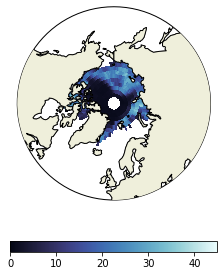

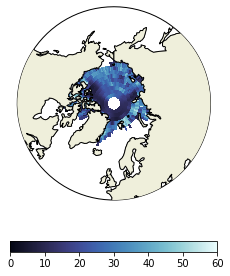

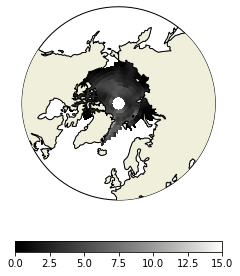

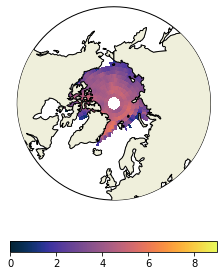

In [15]:
for var in ['sic','sit','snow','temp']:
    values_plot = ds_input_October[var].sel(plus_minus='plus').mean('time').where(np.isnan(mask10)==False).values
    wrap_param, wrap_lon = add_cyclic_point(values_plot,coord=lon,axis=1)
    
    f = plt.figure()
    f.set_size_inches(8.27/2,8.27/2)

    ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
    cs = ax.coastlines(resolution='110m', linewidth=0.5)
    if var == 'sic':
        plt.pcolormesh(wrap_lon,lat,wrap_param*100,transform=ccrs.PlateCarree(),vmax=v_limits[var].sel(direction='vmax'),cmap=cmocean.cm.ice,rasterized=True)#,vmax=0.5,vmin=0
    elif var == 'snow':
        plt.pcolormesh(wrap_lon,lat,wrap_param*1000/300*100,transform=ccrs.PlateCarree(),vmax=v_limits[var].sel(direction='vmax'),cmap=cmocean.cm.gray,rasterized=True)#,vmax=0.5,vmin=0
    elif var == 'sit':
        plt.pcolormesh(wrap_lon,lat,wrap_param*100,transform=ccrs.PlateCarree(),vmax=v_limits[var].sel(direction='vmax'),cmap=cmocean.cm.ice,rasterized=True)#,vmax=0.5,vmin=0
    elif var == 'temp':
        plt.pcolormesh(wrap_lon,lat,wrap_param,transform=ccrs.PlateCarree(),vmax=v_limits[var].sel(direction='vmax'),cmap=cmocean.cm.thermal,rasterized=True)#,vmax=0.5,vmin=0
    ax.set_extent([-180, 180, lat_lim, 90], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black')
    ax.set_boundary(circle, transform=ax.transAxes)
    cbar = plt.colorbar(shrink=0.75,orientation='horizontal')

    plt.tight_layout()
    #f.savefig(plot_path+'param_'+var+'_October_'+assim+'_new.pdf',bbox_inches='tight',dpi=250)

VARIABILITY RANGE ESTIMATES, column 1 in Table 1

In [16]:
var='temp' # or 'sic' or 'sit'
print(ds_input_March[var].mean(dim='time').quantile([0.05,0.95]).values)
print(ds_input_October[var].mean(dim='time').quantile([0.05,0.95]).values) 

[0.49410375 7.14663647]
[0.39805792 5.26939067]


/home/mpim/m300411/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [17]:
print((ds_input_March['snow']*1000/300).mean(dim='time').quantile([0.05,0.95]).values)
print((ds_input_October['snow']*1000/300).mean(dim='time').quantile([0.05,0.95]).values) 

[6.68449163e-05 1.07570901e-01]
[9.79205502e-06 6.10051778e-02]


VARIATION IN BRIGHTNESS TEMPERATURE, column 2 and 3 in Table 1

In [21]:
mask = np.isnan(ds_input_March[var].sel(plus_minus=plus_minus).isel(time=0))==False

In [22]:
plus_minus = 'minus' # or 'plus'
var='temp' # or 'sic' or 'sit' or 'snow'

# March
print((ds_March[var]).sel(plus_minus=plus_minus).where(mask).mean(dim='time').quantile([0.05,0.95]).values)
# October
print((ds_October[var]).sel(plus_minus=plus_minus).where(mask).mean(dim='time').quantile([0.05,0.95]).values)


[-2.99690608 -0.0379229 ]
[-1.68314333 -0.09528469]


/home/mpim/m300411/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/mpim/m300411/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


PLOT FIGURE 5

FIGURE 5b

/home/mpim/m300411/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


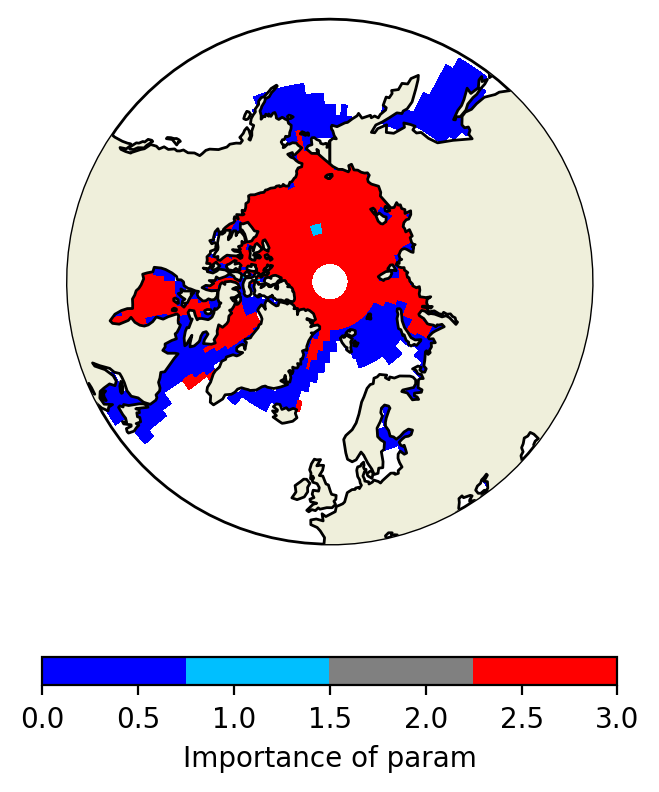

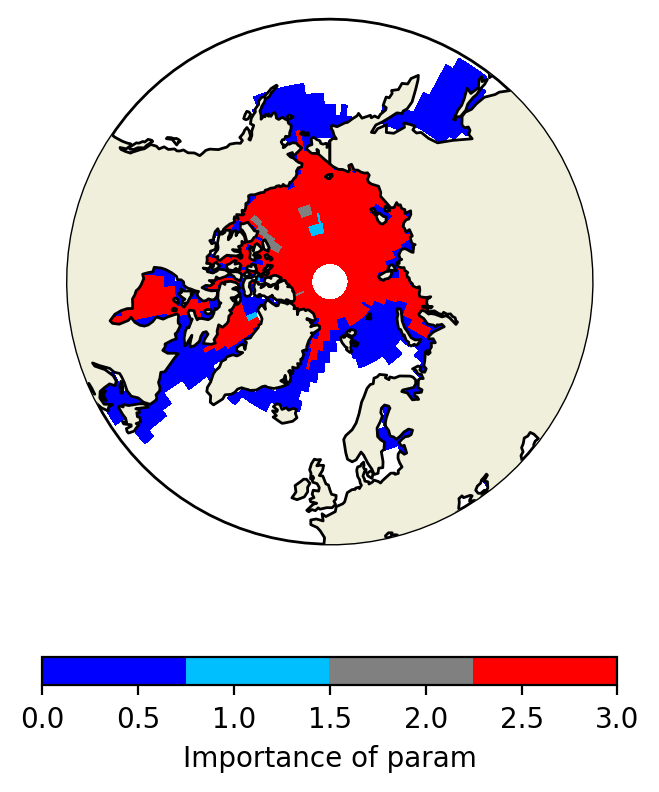

In [27]:
lat_lim = 45

# absolute effect on brightness temperature (because we do not care if the effect is negative or positive)
abs_ds_March = abs(ds_March)
# for each grid cell, the mean effect over time
mean_ds_March = ds_March.mean(dim='time')
# for each grid cell, the mean absoute effect over time
mean_abs_ds_March = abs_ds_March.mean(dim='time')
# to array
compare_mean_abs_ds_March = mean_abs_ds_March.to_array()
# write out index of variable which has the highest value (0 is SIC, 1 is SIT, 2 is SNOW, 3 is TEMP)
argmax0 = compare_mean_abs_ds_March.where(np.isnan(compare_mean_abs_ds_March)==False,0).argmax('variable')

for plus_minus in ['plus','minus']:
    # select sea ice regions
    values_plot = argmax0.where(np.isnan(mask03)==False).sel(plus_minus=plus_minus)
    wrap_param, wrap_lon = add_cyclic_point(values_plot,coord=lon,axis=1)

    f = plt.figure(dpi=200)
    f.set_size_inches(8.27/2,8.27/2)

    ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
    cs = ax.coastlines(resolution='110m', linewidth=0.5)

    cmap = mpl.colors.ListedColormap(['blue', 'deepskyblue', 'grey', 'red'])
    cmap.set_over('0.25')
    cmap.set_under('0.75')

    plt.pcolormesh(wrap_lon,lat,wrap_param,transform=ccrs.PlateCarree(),cmap=cmap,vmin=0,vmax=3,rasterized=True)#,cmap=cmocean.cm.ice)#,vmax=0.5,vmin=0
    ax.set_extent([-180, 180, lat_lim, 90], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black')
    ax.set_boundary(circle, transform=ax.transAxes)

    bounds = [0, 1, 2, 3]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    cbar = plt.colorbar(shrink=0.75,orientation='horizontal')
    cbar.set_label('Importance of param')

    plt.tight_layout()
    #f.savefig(plot_path+'importance_param_'+plus_minus+'_March_'+assim+'_new.pdf',bbox_inches='tight',dpi=250)

Figure 5a

/home/mpim/m300411/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


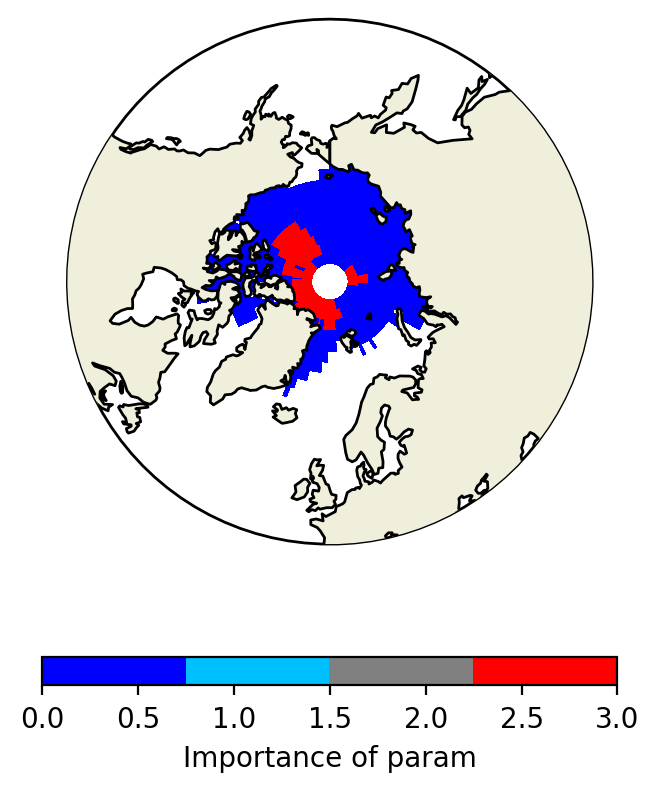

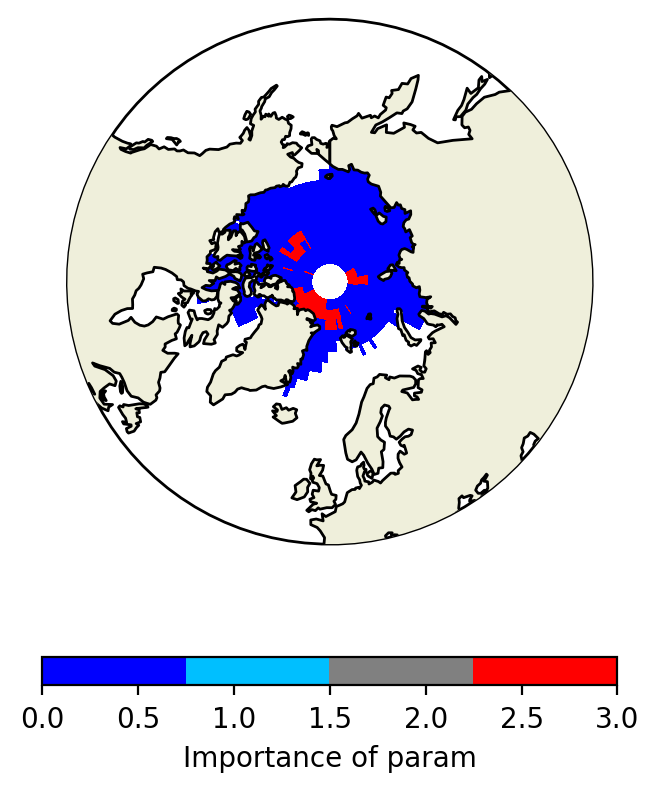

In [28]:
lat_lim = 45

# absolute effect on brightness temperature (because we do not care if the effect is negative or positive)
abs_ds_October = abs(ds_October)
# for each grid cell, the mean effect over time
mean_ds_October = ds_October.mean(dim='time')
# for each grid cell, the mean absoute effect over time
mean_abs_ds_October = abs_ds_October.mean(dim='time')
# to array
compare_mean_abs_ds_October = mean_abs_ds_October.to_array()
# write out index of variable which has the highest value (0 is SIC, 1 is SIT, 2 is SNOW, 3 is TEMP)
argmax0 = compare_mean_abs_ds_October.where(np.isnan(compare_mean_abs_ds_October)==False,0).argmax('variable')

for plus_minus in ['plus','minus']:
    # select sea ice regions
    values_plot = argmax0.where(np.isnan(mask10)==False).sel(plus_minus=plus_minus)    
    wrap_param, wrap_lon = add_cyclic_point(values_plot,coord=lon,axis=1)

    f = plt.figure(dpi=200)
    f.set_size_inches(8.27/2,8.27/2)

    ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
    cs = ax.coastlines(resolution='110m', linewidth=0.5)

    cmap = mpl.colors.ListedColormap(['blue', 'deepskyblue', 'grey', 'red'])
    cmap.set_over('0.25')
    cmap.set_under('0.75')

    plt.pcolormesh(wrap_lon,lat,wrap_param,transform=ccrs.PlateCarree(),cmap=cmap,vmin=0,vmax=3,rasterized=True)#,cmap=cmocean.cm.ice)#,vmax=0.5,vmin=0
    ax.set_extent([-180, 180, lat_lim, 90], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='black')
    ax.set_boundary(circle, transform=ax.transAxes)
    #ax.set_title()

    bounds = [0, 1, 2, 3]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    cbar = plt.colorbar(shrink=0.75,orientation='horizontal')
    cbar.set_label('Importance of param')
    #cbar.ax.tick_params(labelsize=12)

    plt.tight_layout()
    #f.savefig(plot_path+'importance_param_'+plus_minus+'_October_'+assim+'_new.pdf',bbox_inches='tight',dpi=250)